# 4 - Distribution of distances

Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. Also here make a clever choice for the bin sizes and try several values of $m$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
# Read data from file and make sure earthquakes are orderd by time

df = pd.read_table("SouthCalifornia-1982-2011_Physics-of-Data.dat",sep=" ")
df = df.sort_values(by = ['time'])

In [3]:
# Set the value of m and select data with magnitude major or qequal than m

m = 3
df_red = copy.deepcopy(df[df['magnitude'] >= m])

print("Number of selected earthquakes: ",df_red.shape[0])

Number of selected earthquakes:  11923


In [4]:
# Compute the distance and drop the last earthquake

df_red['distance'] = ((df_red['longitude'].diff(periods=-1))**2 + (df_red['latitude'].diff(periods=-1))**2 + (df_red['depth'].diff(periods=-1))**2)**(1/2)
df_red = df_red.dropna()

## 4.1 - Histogram with regular binning

In [5]:
# Set a number of bins

nbin = 3000
wbin = (df_red['distance'].max() - df_red['distance'].min())/nbin

print("Width of bins: ", wbin)

Width of bins:  339.2973483410987


/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-10000, 800000)

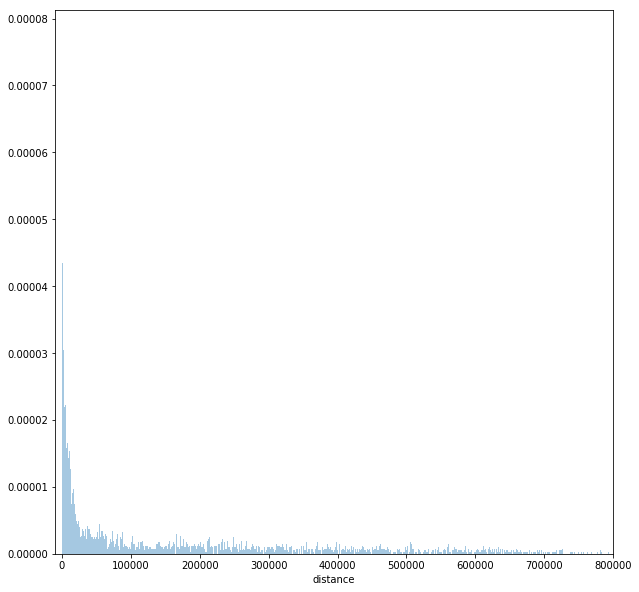

In [6]:
# Plot the histogram with regular bins

fig, ax = plt.subplots(figsize=(10,10))

ax = sns.distplot(df_red['distance'], bins=nbin, kde=False, norm_hist=True)
ax.set_xlim(-10000,800000)
#ax.set_ylim(0,0.00005)

In [7]:
# Plot the histogram with regular binning in log-log scale

ax = sns.distplot(df_red['distance'], bins=nbin, kde=False, norm_hist=True)

plt.close()

/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [8]:
# Import data from the histogram with regular binning

import matplotlib.patches

width = np.array([h.get_width() for h in ax.patches])
edge = np.array([h.get_xy()[0] for h in ax.patches]) # Right edges
x = np.add(edge,-width/2.) # Center of bins
y = [h.get_height() for h in ax.patches] # Frequency of data

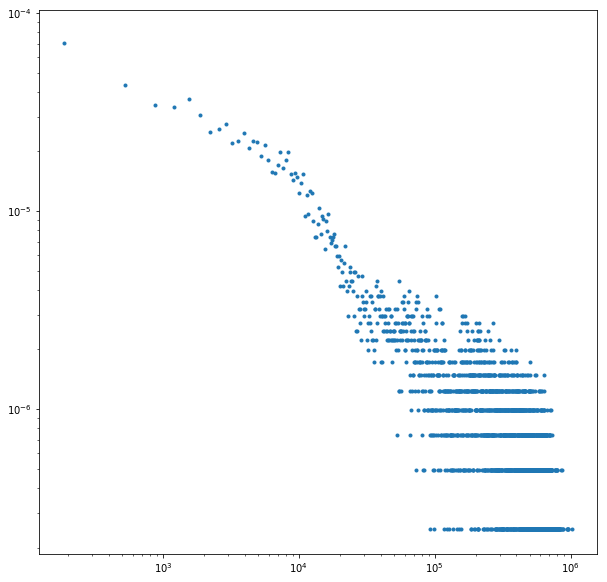

In [9]:
# Dot-visualization of the histogram with regular binning in log-log scale

fig, ax = plt.subplots(figsize=(10,10))

plt.plot(x,y,'.')

plt.xscale('log')
plt.yscale('log')

## 4.2 Histogram with logarithmic binning

In [10]:
# Set logarithmic binning

width = 1000*np.logspace(0, 3, int(np.sqrt(df_red.shape[0]))+1)

# Compute the right edges

edge = np.cumsum(width)

/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 500000)

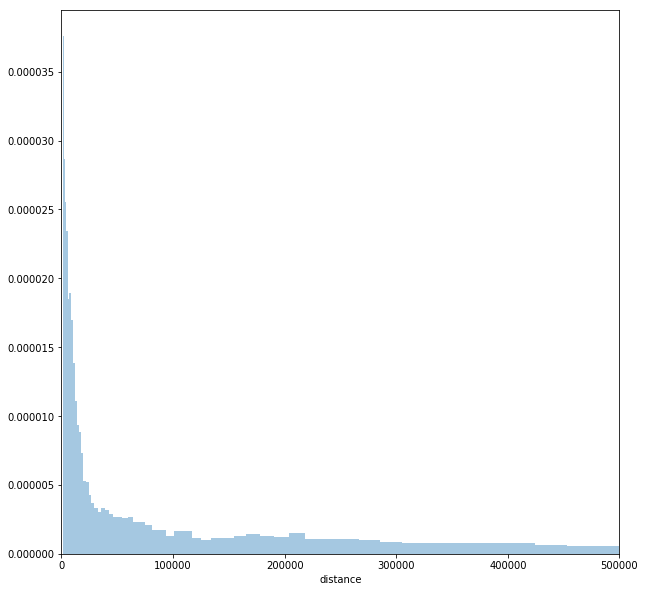

In [11]:
# Histogram with logarithmic binning

fig, ax = plt.subplots(figsize=(10,10))

ax = sns.distplot(df_red['distance'], bins = edge, kde=False, norm_hist=True)

ax.set_xlim(0,500000)
#ax.set_xscale('log')
#ax.set_yscale('log')

In [12]:
# Import data from the histogram with logarithmic binning

edge = np.array([h.get_xy()[0] for h in ax.patches]) 
width = np.array([h.get_width() for h in ax.patches]) # Right edges
x = np.add(edge, -width/2.) # Center of the bin
y = [h.get_height() for h in ax.patches] # Frequency of data 

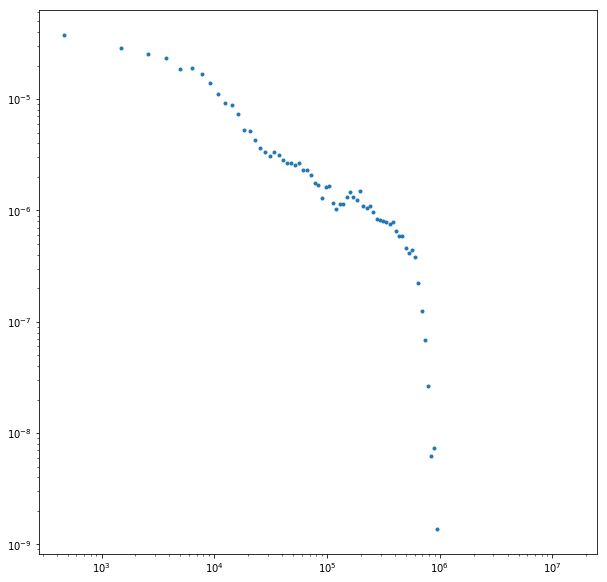

In [13]:
# Dot-visualization of the histogram with logarithmic binning in log-log scale

fig, ax = plt.subplots(figsize=(10,10))

plt.plot(x,y,'.')

plt.xscale('log')
plt.yscale('log')

## 4.3 - Linear Regression with tuning of lower cutoff

In [14]:
# Compute vectors with logarithm of frequences and centers of edges in order to perform linear regression

xy = pd.DataFrame({'x':x, 'y':y})

xy = xy[ xy.y != 0 ] # Drop bin with zero frequency in order to compute the logarithm

x = np.log10(np.array(xy.x))
y = np.log10(np.array(xy.y))

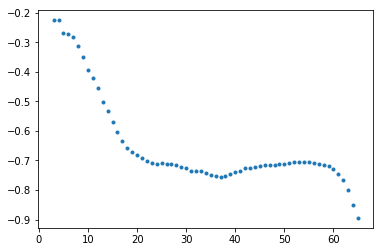

In [15]:
# Perfom linear regression after removing elements from x_m to the end of the vector

from sklearn.linear_model import LinearRegression

alpha = []
x_part = []

for i in range(3,len(x)):
    x_prov = x[:i]
    y_prov = y[:i]
    model = LinearRegression().fit(x_prov.reshape(-1,1), y_prov.reshape(-1,1))
    alpha.append(model.coef_[0][0])
    x_part.append(i)
    
plt.plot(x_part,alpha,'.')

In [16]:
# Choose best x_min

slope = []
chosen_index = []

for i in range(len(x_part)-5):
    x_set = np.array(x_part[i:i+5])
    y_set = np.array(alpha[i:i+5])
    model = LinearRegression().fit(x_set.reshape(-1,1), y_set.reshape(-1,1))
    chosen_index.append(i+5)
    slope.append(model.coef_[0][0])

data_tuples = list(zip(chosen_index,slope))

g = pd.DataFrame(data_tuples,columns=['x_min_index','slope'])
g['slope'] = np.abs(g['slope'])
x_min_index =  np.array(g.loc[g['slope'] == g['slope'].min()])

In [17]:
# Perform linear regression with the best value x_min

x_corr = x[1:int(x_min_index[0][0])]
y_corr = y[1:int(x_min_index[0][0])]

model = LinearRegression().fit(x_corr.reshape(-1,1), y_corr.reshape(-1,1))

print('Intercept:', model.intercept_)
print('Slope:', model.coef_)

Intercept: [-2.06499021]
Slope: [[-0.73987282]]


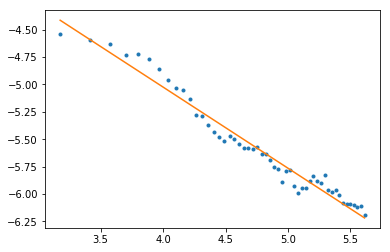

In [18]:
# Plot fit

l = np.linspace(x_corr.min(), x_corr.max(),len(x_corr))

plt.plot(x_corr,y_corr,'.')
plt.plot(l, model.intercept_[0] + model.coef_[0][0]*l)

## 4.4 - Analysis for different values of m

/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/michelepuppin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


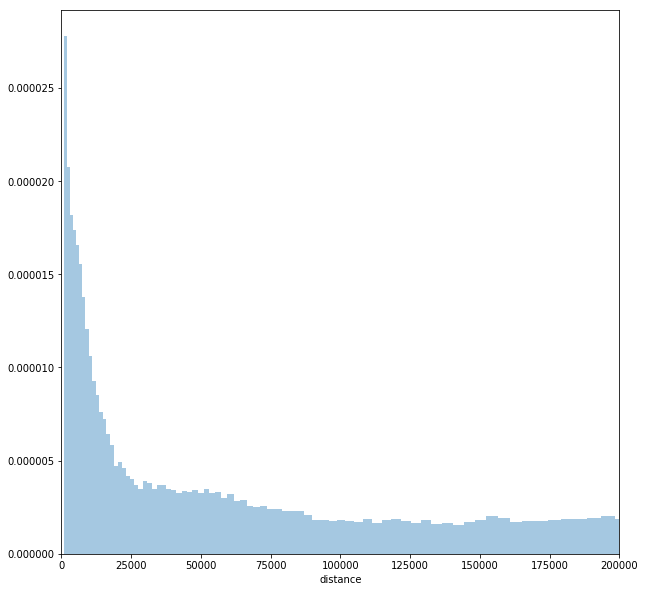

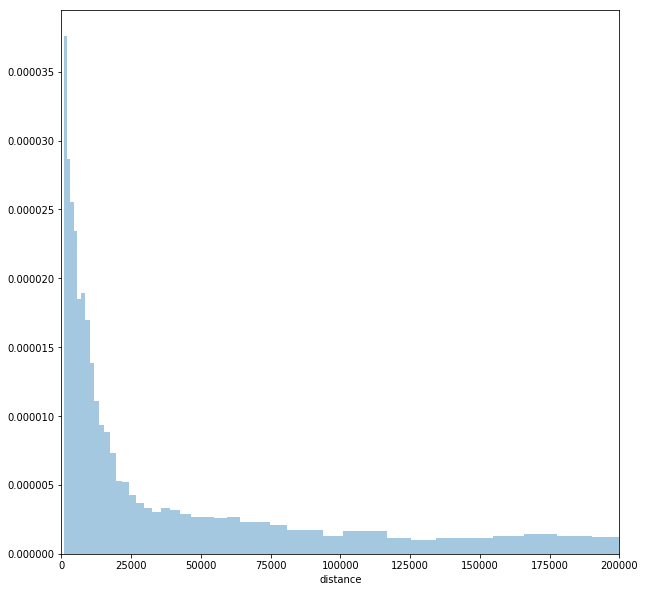

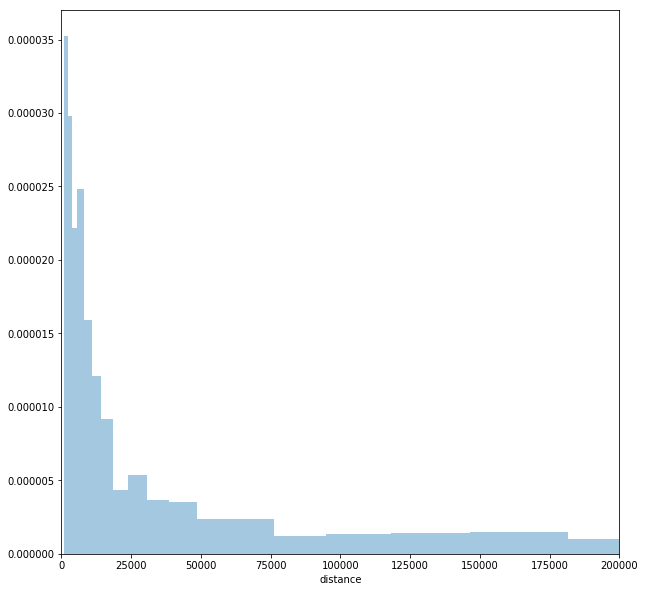

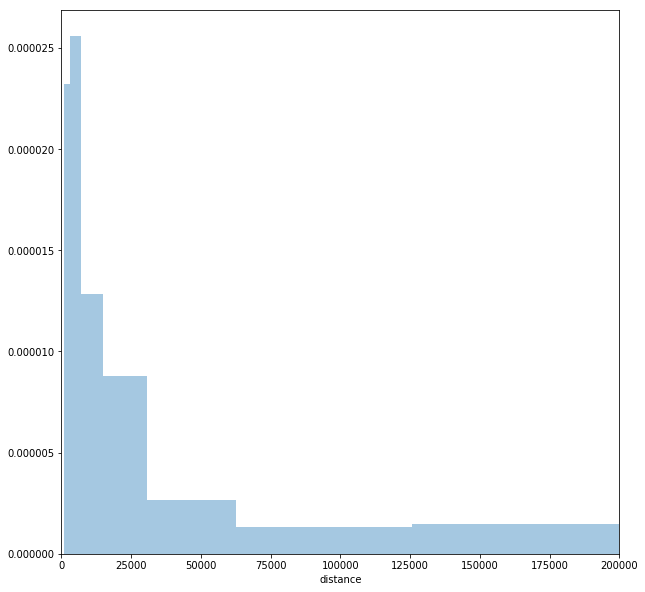

In [19]:
# Set varius the value of m

mag = [2,3,4,5]
xx = [0,0,0,0]
yy = [0,0,0,0]
max_dist = [0,0,0,0]

lim = [200000,200000,200000,200000]


for i in range(len(mag)):
    df_red = copy.deepcopy(df[df['magnitude'] >= mag[i]])
    df_red['distance'] = np.sqrt((df_red['longitude'].diff(periods=-1))**2 + (df_red['latitude'].diff(periods=-1))**2 + (df_red['depth'].diff(periods=-1))**2)
    df_red = df_red.dropna()
    max_dist[i] = df_red['distance'].mean()
    width = 1000*np.logspace(0, 3, int(np.sqrt(df_red.shape[0]))+1)
    edge = np.cumsum(width)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlim(0,lim[i])
    ax = sns.distplot(df_red['distance'], bins = edge, kde=False, norm_hist=True)
    edge = np.array([h.get_xy()[0] for h in ax.patches]) 
    width = np.array([h.get_width() for h in ax.patches])
    xx[i] = np.add(edge, -width/2.)
    yy[i] = np.array([h.get_height() for h in ax.patches])

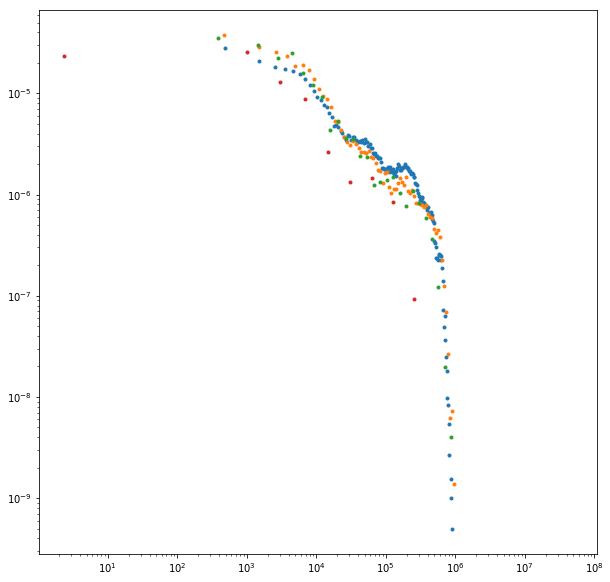

In [20]:
# Plot for all m in log-log scale

fig, ax = plt.subplots(figsize=(10,10))

for i in range(len(mag)):
    plt.plot(xx[i],yy[i],'.')

plt.xscale('log')
plt.yscale('log')

plt.show()

## 4.5 - Rescaling

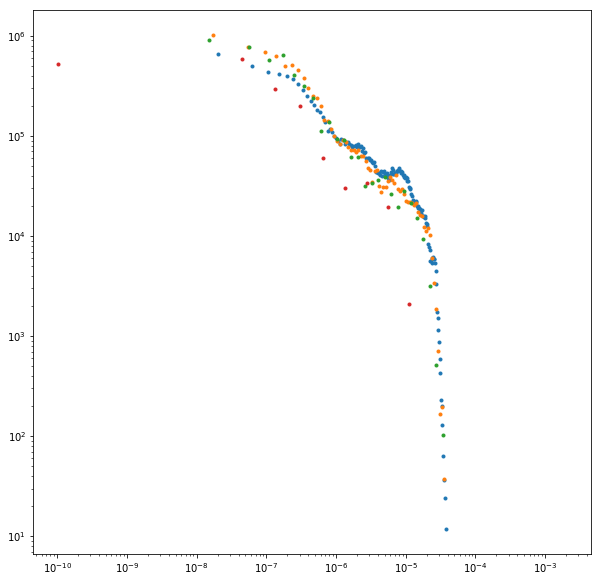

In [22]:
# Rescale distance multiplying frequency for maximum distance and dividing distance for maximum distance


for i in range(len(mag)):
    xx[i] = xx[i]/max_dist[i]
    yy[i] = yy[i]*max_dist[i]

fig, ax = plt.subplots(figsize=(10,10))

for i in range(len(mag)):
    plt.plot(xx[i],yy[i],'.')

plt.xscale('log')
plt.yscale('log')

plt.show()